## TRABALHO 2.2 - RESPOSTA A UM IMPACTO

*Aluno: Caio de Britto* | *Matrícula: 00231217*

### 1. INTRODUÇÃO

O objetivo deste trabalho é avaliar a resposta do pórtico definido no trabalho 2.1 sob a ação de um impacto causado no grau de liberdade 11 (ponto que gerará maior amplitude). Além disso, será determinado o amortecimento em razão do crítico para todos os modos de vibração.

In [206]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sc

import pickle as pk
with open('data/sample_KM.pk', 'rb') as target:
    K, M = pk.load(target)

### 2. MODOS DE VIBRAÇÃO DA ESTRUTURA

Em posse das matrizes de massa M e de rigidez K do pórtico, serão calculados, a seguir, os autovalores e autovetores da matriz D que é o produto da matriz inversa de K pela matriz M. Os autovalores estão associados às frequências naturais da estrutura, enquanto os autovetores caracterizam as formas modais.

In [207]:
# Uses scipy to solve the standard eigenvalue problem
w, Phi = sc.eig(K, M)

# Ensure ascending order of eigenvalues
iw   = w.argsort()
w  = w[iw]
Phi = Phi[:,iw]

# Eigenvalues to vibration frequencies
wk  = np.sqrt(np.real(w)) 
fk  = wk/2/np.pi

Abaixo, serão plotadas as quatro primeiras formas modais do pórtico em questão.

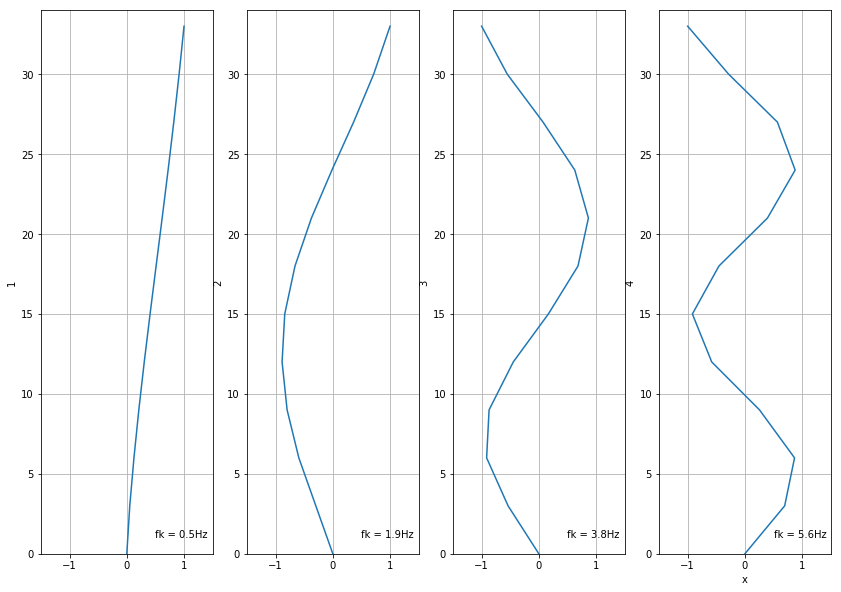

In [208]:
plt.figure(33, figsize=(40,10))
x = np.arange(0,36,3)

for k in range(4):
    pk = np.zeros(12)
    pk[1:] = Phi[::1,k]
    pk /= np.max(np.abs(pk))   # adjust scale for unity amplitude    
    
    plt.subplot(1,11,k+1)
    plt.plot(pk, x)
    
    plt.xlim(-1.5, 1.5);
    plt.ylim(0.0,  34.0);  plt.ylabel(str(k+1));
    plt.text(0.5, 1.0, 'fk = {0:3.1f}Hz'.format(fk[k]));
    plt.grid(True)

plt.xlabel('x');

### 3. RESPOSTA NÃO AMORTECIDA A UM IMPACTO NO TOPO DO PÓRTICO

Será aplicada uma carga de 60000 N no topo do pórtico (nó 11). O período de duração deste impacto será td = Tn/4, onde Tn é o período natural associado à maior frequência natural da estrutura. Considera-se que a massa que impacta contra o pórtico é de 5000 kg. O objetivo desta análise é determinar a reposta (em deslocamentos) não amortecida do nó que recebe o impacto.

Nas linhas de código abaixo, são calculados os vetores de velocidades iniciais e deslocamentos iniciais devidos ao impacto. Ressalta-se que o único elemento não nulo dentro do vetor de velocidades iniciais será o valor correspondente à velocidade inicial do nó que recebe o impacto (nó 11).

In [174]:
fn_max = np.max(fk)    # Retorna a maior frquência natural          
F0 = 60000             # Impacto de 60000 N
Tn = 1/fn_max          # Período natural associado à maior frequência
td = Tn/4              # Tempo de duração do impacto
m = 5000               # Massa do projétil
v0 = F0*td/m           # Velocidade inicial aplicada ao nó

V0 = [0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, v0]  # Vetor de velocidades iniciais - não nulo só no nó que recebe o impacto
U0 = np.zeros(11)                         # Vetor de deslocamentos iniciais - todos nulos

print('Velocidade Inicial no Nó 11 =',v0,'m/s')

Velocidade Inicial no Nó 11 = 0.17681752837843914 m/s


Tendo-se calculado os vetores de velocidades e deslocamentos iniciais, procede-se ao cálculo da repsosta em deslocamentos do nó 11. Para isso, foram escritas as seguintes linhas de código.

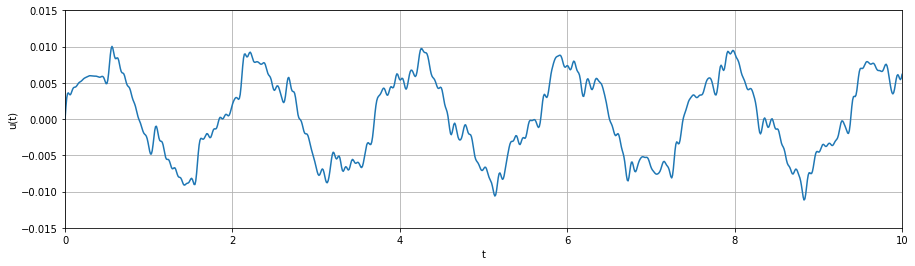

In [212]:
Phi_T = Phi.transpose()      #Phi transposto             
U_max = np.zeros(11)         #Vetor que armazenará os deslocamentos máximos de cada nó

for k in range (11):

    Mi=np.dot((np.dot(Phi_T[k],M)),Phi_T[k]) 
    #O primeiro Phi_T[k] é um vetor linha e o segundo é um vetor coluna, ambos correspondem ao autovetor K.
    u_max = -(np.dot(np.dot(Phi_T[k],M),V0))/(wk[k]*np.sin(np.pi/2)*Mi)  #Calcula o deslocamento máximo a cada nó
    U_max[k]=u_max                                                       #Armazena os valores u_max em um vetor
    
t = np.linspace(0,10,1000) #discretizando um intervalo de tempo de 0 a 10 segundos em 1000 pontos
uk = np.zeros((11,1000))   #criando uma matriz 11x1000 que armazenará o deslocamento em cada nó em cada instante de t

for k in range (11):
    uk[k,:] = U_max[k]*np.cos(-wk[k]*t-np.pi/2)  #deslocamento no instante t. O Phi será multiplicado depois
    
u = np.dot(Phi, uk) #multiplicando o Phi

plt.figure(2, figsize=(15,4))
plt.plot(t,u[10,:]) #A curva será plotada para o deslocamento do nó 11 
plt.xlim(0, 10); plt.xlabel("t");
plt.ylim (-0.015,0.015); plt.ylabel("u(t)");
plt.grid(True)

In [213]:
u_pico = max(abs(u[10])) 
print('O máximo deslocamento do nó 11 é {0:1.5} cm'.format(u_pico*100))

O máximo deslocamento do nó 11 é 1.1163 cm


Percebe-se que o gráfico u(t) é senoidal e pode-se facilmente constatar que a a frequência 0.54 Hz (Tn = 1.86 s) respectiva à forma modal 1 é observada.

### 4. AMORTECIMENTO

A Matriz de Amortecimento de Rayleigh (C) é uma combinação linear das matrizes de rigidez (K) e de massa (M). Para montá-la, atribuiu-se um amortecimento em razão do crítico ζ = 1% para os dois primeiros modos de vibração. Como as frequências naturais desses dois modos são conhecidas, podem ser calculados os parâmetros α0 e α1. Por fim, determina-se o amortecimento em razão do crítico para todos nós da estrutura.

In [205]:
zeta = np.zeros(11)
zeta[0] = 0.01 #zeta no modo de vibração 1
zeta[1] = 0.01 #zeta no modo de vibração 2
alfa1 = 2*(zeta[0]*wk[0]-zeta[1]*wk[1])/(wk[0]**2-wk[1]**2)
alfa0 = 2*zeta[0]*wk[0]-alfa1*wk[1]**2

for k in range (9):
    zeta [k+2] = (alfa0/(2*wk[k+2]))+(alfa1*wk[k+2]/2)
    
print(zeta)  #amortecimento para todos os nós

[0.01       0.01       0.01309123 0.02136155 0.02971624 0.03784647
 0.045831   0.05326331 0.05947656 0.0647331  0.06886366]
